# DOE 本番解析用 (doe-5)

In [33]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

### Matplotlib のフォント設定（オプション）

In [34]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイルの読込

In [35]:
name_doe = "doe-5"
name_code = "7011"
date_str = str(datetime.datetime.now().date())  # 保存ファイル目に付与する本日の日付
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file_all = sorted(os.listdir(path_dir))
list_file = list_file_all  # ここで最新のデータに絞るかどうかを決める
print(list_file)
list_df = list()
for file in list_file:
    path = os.path.join(path_dir, file)
    list_df.append(pd.read_csv(path))
n_tick = len(list_df)
print(f"\n# of tick files : {n_tick}")
df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)

['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv']

# of tick files : 25


## サマリ集計

In [36]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
with open("summary.html", "w", encoding="utf-8") as f:
    f.write(html)

    PERIOD_MA_1  PERIOD_MA_2  trade  total
0            30          300  15.44   3.32
1            30          400  12.56   4.60
2            30          500  11.44   6.80
3            30          600  10.96   5.56
4            30          700  11.12   0.00
5            60          300  10.88   5.68
6            60          400  10.24   9.40
7            60          500   8.40  10.44
8            60          600   8.32   9.88
9            60          700   8.48   7.56
10           90          300   7.84   4.92
11           90          400   6.72   4.40
12           90          500   6.48   6.76
13           90          600   5.84   7.16
14           90          700   5.68   2.64
15          120          300   7.28   0.60
16          120          400   6.00  -1.68
17          120          500   5.76   1.20
18          120          600   5.52   1.80
19          120          700   5.20   3.64
20          150          300   6.64   0.56
21          150          400   4.88   9.24
22         

## 【収益】分散分析 (ANOVA)

In [37]:
# オリジナルのサマリデータをコピーして利用
df_anova = df_summary.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df_anova に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MA_1:PERIOD_MA_2"
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

=== ANOVA (up to 2-way interactions) ===
                             sum_sq    df         F    PR(>F)
PERIOD_MA_1               13.312800   1.0  1.114969  0.303001
PERIOD_MA_2                1.591328   1.0  0.133276  0.718710
PERIOD_MA_1:PERIOD_MA_2    4.787344   1.0  0.400948  0.533436
Residual                 250.741424  21.0       NaN       NaN


### 主効果

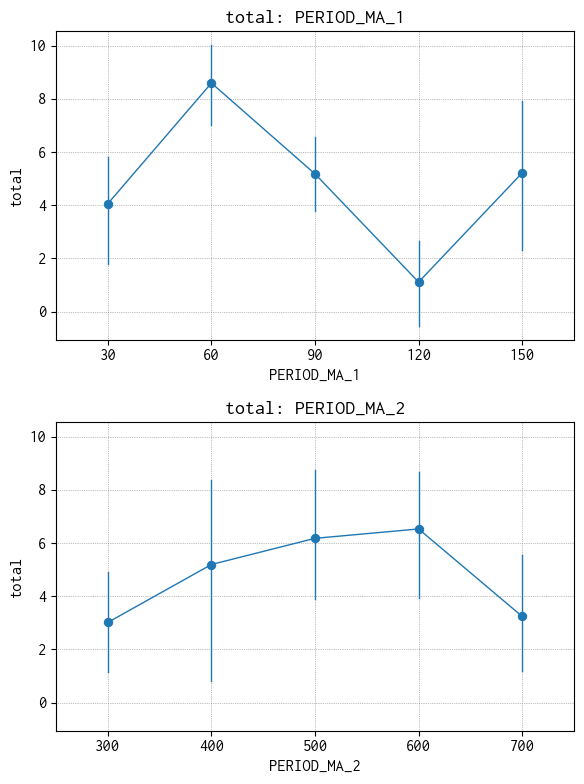

In [38]:
# === 各因子の平均効果を可視化 ===
list_col = ["PERIOD_MA_1", "PERIOD_MA_2"]
target = "total"
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_effects_main_{target}_{date_str}.png"
)

plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(len(list_col), 1, figsize=(6, 4 * len(list_col)))

y_min_global = 1e7
y_max_global = -1e7
for i, col in enumerate(list_col):
    sns.pointplot(
        x=col,
        y=target,
        data=df_summary,
        markersize=6,
        linewidth=1,
        errorbar="ci",
        ax=ax[i],
    )
    ax[i].grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    ax[i].set_title(f"{target}: {col}")

    y_min, y_max = ax[i].get_ylim()
    if y_min < y_min_global:
        y_min_global = y_min
    if y_max_global < y_max:
        y_max_global = y_max

for i in range(len(list_col)):
    ax[i].set_ylim(y_min_global, y_max_global)

plt.tight_layout()
plt.savefig(output)
plt.show()

### 交互作用

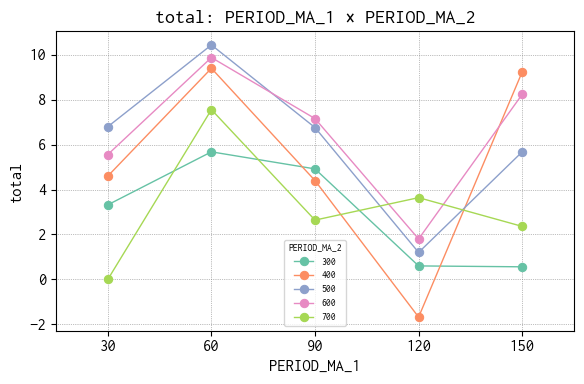

In [39]:
target = "total"
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{name_code}_doe_effects_interaction_{target}_{date_str}.png",
)
"""
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
]

a, b = pairs[0]
"""
a = "PERIOD_MA_1"
b = "PERIOD_MA_2"

plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.pointplot(
    x=a,
    y=target,
    hue=b,
    data=df_summary,
    markersize=6,
    linewidth=1,
    errorbar=None,
    palette="Set2",
    ax=ax,
)
ax.set_title(f"{target}: {a} × {b}")
ax.set_xlabel(a)
ax.set_ylabel(target)
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 凡例のタイトル
lg = ax.legend(fontsize=7)
lg.set_title(b, prop={"size": 7})

plt.tight_layout()
plt.savefig(output)
plt.show()

## 【収益】重回帰分析 (MULREG)

In [40]:
# ---------------------------------------------------------
# 2. RSM 用の二次モデルを構築
#    total ~ PERIOD_MA_1 + PERIOD_MA_2 + 交互作用 + 二乗項
# ---------------------------------------------------------
formula = """
total ~ PERIOD_MA_1 + PERIOD_MA_2
        + I(PERIOD_MA_1**2) + I(PERIOD_MA_2**2)
        + PERIOD_MA_1:PERIOD_MA_2
"""
model = smf.ols(formula, data=df_summary).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     1.282
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.312
Time:                        10:47:51   Log-Likelihood:                -61.603
No. Observations:                  25   AIC:                             135.2
Df Residuals:                      19   BIC:                             142.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [41]:
# ---------------------------------------------------------
# 3. 予測用のグリッドを作成して応答曲面を描く準備
# ---------------------------------------------------------
ma1_range = np.linspace(
    df_summary["PERIOD_MA_1"].min(), df_summary["PERIOD_MA_1"].max(), 100
)
ma2_range = np.linspace(
    df_summary["PERIOD_MA_2"].min(), df_summary["PERIOD_MA_2"].max(), 100
)
MA1, MA2 = np.meshgrid(ma1_range, ma2_range)

grid = pd.DataFrame({"PERIOD_MA_1": MA1.ravel(), "PERIOD_MA_2": MA2.ravel()})
grid["pred"] = model.predict(grid)

### 3D 応答曲面プロット

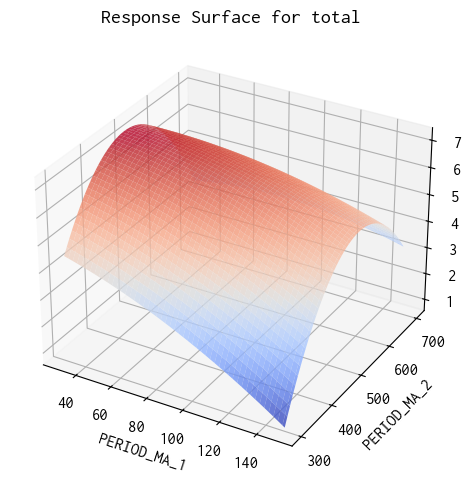

In [42]:
# ---------------------------------------------------------
# 4. 3D 応答曲面プロット（matplotlib）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    MA1, MA2, grid["pred"].values.reshape(MA1.shape), cmap="coolwarm", alpha=0.8
)

ax.set_xlabel("PERIOD_MA_1")
ax.set_ylabel("PERIOD_MA_2")
ax.set_title("Response Surface for total")

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_surface_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()

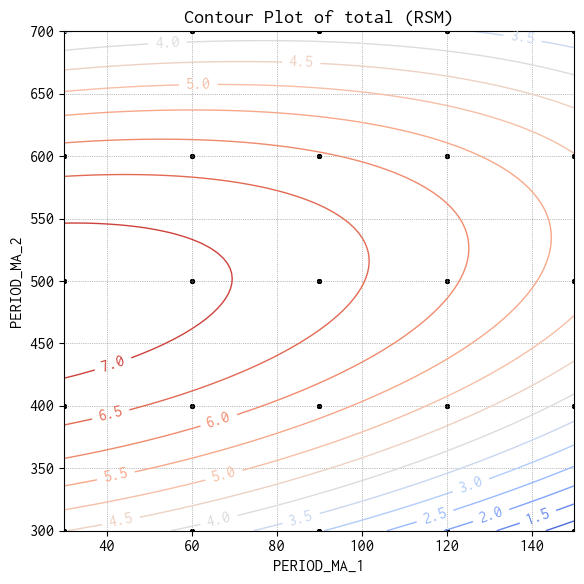

In [43]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

Z = grid["pred"].values.reshape(MA1.shape)

# 等高線（線にグラデーション）
cont = ax.contour(MA1, MA2, Z, levels=15, cmap="coolwarm", linewidths=1)

# 数値ラベル
ax.clabel(cont, inline=True, fontsize=12, fmt="%.1f")

ax.set_xlabel("PERIOD_MA_1")
ax.set_ylabel("PERIOD_MA_2")
ax.set_title("Contour Plot of total (RSM)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 実験点を黒点で追加
ax.scatter(
    df["PERIOD_MA_1"], df["PERIOD_MA_2"], color="black", s=5, alpha=0.9  # 点の大きさ
)

# 最適点
# ax.scatter([90], [500], marker="o", facecolor="cyan", edgecolor="darkblue", s=200)

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_contour_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

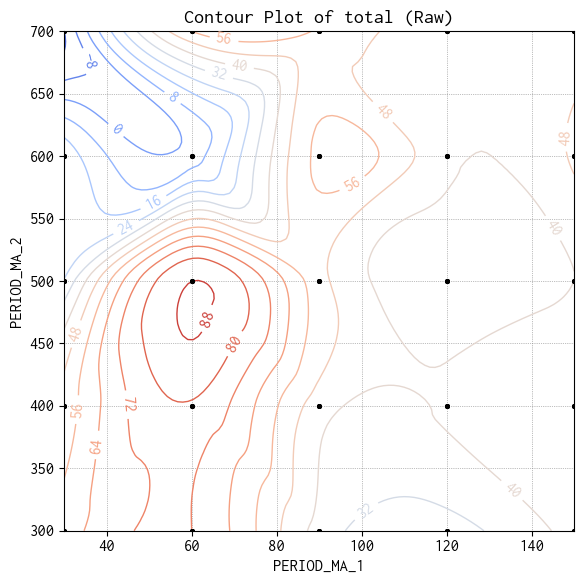

In [44]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
ax.clabel(cont, inline=True, fontsize=12)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=5, zorder=3)

# 最適点
# ax.scatter([60], [500], marker="o", facecolor="cyan", edgecolor="darkblue", s=200)

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_raw_contour_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()